##  SMI Behaviour in Deep Neural Networks

In [24]:
import tensorflow as tf
from tensorflow.keras.layers import Flatten, Dense
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import pickle

from estimators.smi_estimator import compute_smi

### Load and Preprocess Dataset

In [21]:
def normalize_img(image, label):
    return tf.cast(image, tf.float32) / 255., label

def onehot_encode(image, label, n_classes):
    label = tf.one_hot(label, depth=n_classes)
    return image, label

(ds_train, ds_test), ds_info = tfds.load('mnist',
                                         split=['train', 'test'],
                                         data_dir = '../tensorflow_datasets/',
                                         shuffle_files=True,
                                         as_supervised=True,
                                         with_info=True,)
n_classes = ds_info.features['label'].num_classes
ds_train = ds_train.map(lambda x,y: normalize_img(x,y), num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.map(lambda x,y: onehot_encode(x,y,n_classes), num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.batch(256).cache().prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(lambda x,y: normalize_img(x,y), num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.map(lambda x,y: onehot_encode(x,y,n_classes), num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(256).cache().prefetch(tf.data.AUTOTUNE)

### Create and Train Model

In [16]:
model = tf.keras.Sequential()
model.add(Flatten(input_shape=(ds_train.element_spec[0].shape[1:])))
model.add(Dense(1024, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(ds_train.element_spec[1].shape[1], activation='linear'))

In [17]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
model.compile(loss=loss_fn, optimizer=optimizer, metrics=['accuracy'])

all_train_loss = []
all_train_acc = []
all_test_loss = []
all_test_acc = []

train_loss, train_acc = model.evaluate(ds_train)
test_loss, test_acc = model.evaluate(ds_test)

all_train_loss.append(train_loss)
all_train_acc.append(train_acc)
all_test_loss.append(test_loss)
all_test_acc.append(test_acc)

model.save('../results/SMI_Generalization/saved_models_dpi/epoch_00.keras')

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='../results/SMI_Generalization/saved_models_dpi/epoch_{epoch:02d}.keras',
    save_weights_only=False,
    save_best_only=False,
    verbose=1
)

history = model.fit(ds_train, verbose=1, epochs=50, validation_data=ds_test, callbacks=[model_checkpoint_callback])

all_train_loss.extend(history.history['loss'])
all_train_acc.extend(history.history['accuracy'])
all_test_loss.extend(history.history['val_loss'])
all_test_acc.extend(history.history['val_accuracy'])

40/40 [==============================] - 0s 6ms/step - loss: 2.3057 - accuracy: 0.1000
Epoch 1/50


2024-07-01 14:52:19.425355: I external/local_xla/xla/service/service.cc:168] XLA service 0x563ce2412980 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-01 14:52:19.425400: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2024-07-01 14:52:19.431596: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-01 14:52:19.471828: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:467] Loaded cuDNN version 90100
I0000 00:00:1719845539.561893 2298508 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


218/235 [==========================>...] - ETA: 0s - loss: 0.2250 - accuracy: 0.9292
Epoch 1: saving model to ../results/SMI_Generalization/saved_models_dpi/epoch_01.keras
235/235 [==============================] - 3s 4ms/step - loss: 0.2174 - accuracy: 0.9318 - val_loss: 0.1040 - val_accuracy: 0.9688
Epoch 2/50
221/235 [===========================>..] - ETA: 0s - loss: 0.0817 - accuracy: 0.9753
Epoch 2: saving model to ../results/SMI_Generalization/saved_models_dpi/epoch_02.keras
235/235 [==============================] - 1s 3ms/step - loss: 0.0815 - accuracy: 0.9753 - val_loss: 0.1082 - val_accuracy: 0.9674
Epoch 3/50
229/235 [============================>.] - ETA: 0s - loss: 0.0567 - accuracy: 0.9826
Epoch 3: saving model to ../results/SMI_Generalization/saved_models_dpi/epoch_03.keras
235/235 [==============================] - 1s 3ms/step - loss: 0.0567 - accuracy: 0.9826 - val_loss: 0.1342 - val_accuracy: 0.9642
Epoch 4/50
232/235 [============================>.] - ETA: 0s - loss:

Text(0, 0.5, 'Accuracy')

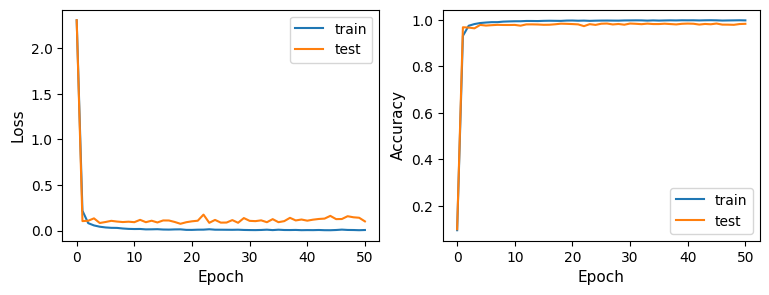

In [18]:
fig, axs =  plt.subplots(1, 2, figsize=(9, 3), dpi=100)
axs[0].plot(range(51), all_train_loss, c='tab:blue', label='train')
axs[0].plot(range(51), all_test_loss, c='tab:orange', label='test')
axs[0].legend(loc='upper right')
axs[0].set_xlabel('Epoch', fontsize=11)
axs[0].set_ylabel('Loss', fontsize=11)
axs[1].plot(range(51), all_train_acc, c='tab:blue', label='train')
axs[1].plot(range(51), all_test_acc, c='tab:orange', label='test')
axs[1].legend(loc='lower right')
axs[1].set_xlabel('Epoch', fontsize=11)
axs[1].set_ylabel('Accuracy', fontsize=11)
plt.show()

### Compute SMI

In [22]:
x_list = []
y_list = []
# for x, y in ds_train:
#     x_list.extend(x.numpy())
#     y_list.extend(y.numpy())
for x, y in ds_test:
    x_list.extend(x.numpy())
    y_list.extend(y.numpy())

smi_all_epochs = []
for epoch in range(51):
    if epoch % 5 == 0:
        print(f'Epoch: {epoch:02}/51')
        smi_all_layers = []
        model = tf.keras.models.load_model(f"../results/SMI_Generalization/saved_models_dpi/epoch_{epoch:02d}.keras")
        for l,layer in enumerate(model.layers):
            int_model = tf.keras.Model(inputs=model.inputs, outputs=model.layers[l].output)
            activity = int_model.predict(np.array(x_list), verbose=0, batch_size=256)
            smi = compute_smi(activity, np.array(y_list), proj_x=True, proj_y=False, n_projs=500, method='ksg_cd')
            smi_all_layers.append(smi)
            print(f'Layer {l}: SI(T;Y) = {smi:.3f}')
        smi_all_epochs.append(smi_all_layers)

Epoch: 00/51
Layer 0: SI(T;Y) = 0.150
Layer 1: SI(T;Y) = 0.137
Layer 2: SI(T;Y) = 0.122
Layer 3: SI(T;Y) = 0.115
Layer 4: SI(T;Y) = 0.107
Layer 5: SI(T;Y) = 0.104
Epoch: 05/51
Layer 0: SI(T;Y) = 0.148
Layer 1: SI(T;Y) = 0.209
Layer 2: SI(T;Y) = 0.400
Layer 3: SI(T;Y) = 0.715
Layer 4: SI(T;Y) = 0.873
Layer 5: SI(T;Y) = 1.063
Epoch: 10/51
Layer 0: SI(T;Y) = 0.155
Layer 1: SI(T;Y) = 0.203
Layer 2: SI(T;Y) = 0.418
Layer 3: SI(T;Y) = 0.772
Layer 4: SI(T;Y) = 0.944
Layer 5: SI(T;Y) = 1.130
Epoch: 15/51
Layer 0: SI(T;Y) = 0.153
Layer 1: SI(T;Y) = 0.213
Layer 2: SI(T;Y) = 0.442
Layer 3: SI(T;Y) = 0.814
Layer 4: SI(T;Y) = 0.977
Layer 5: SI(T;Y) = 1.144
Epoch: 20/51
Layer 0: SI(T;Y) = 0.152
Layer 1: SI(T;Y) = 0.213
Layer 2: SI(T;Y) = 0.441
Layer 3: SI(T;Y) = 0.828
Layer 4: SI(T;Y) = 1.010
Layer 5: SI(T;Y) = 1.149
Epoch: 25/51
Layer 0: SI(T;Y) = 0.151
Layer 1: SI(T;Y) = 0.203
Layer 2: SI(T;Y) = 0.433
Layer 3: SI(T;Y) = 0.845
Layer 4: SI(T;Y) = 1.037
Layer 5: SI(T;Y) = 1.161
Epoch: 30/51
Layer 0: 

In [25]:
results = {}
results['smi_all_epochs'] = smi_all_epochs

with open(f"../results/SMI_Generalization/smi_dpi", 'wb') as f:
    pickle.dump(results, f, protocol=pickle.HIGHEST_PROTOCOL)

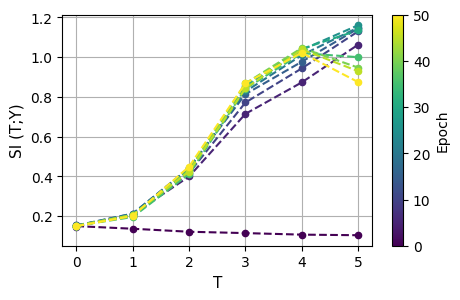

In [68]:
with open('../results/SMI_Generalization/smi_dpi', 'rb') as f:
    results = pickle.load(f)
    
smi_all_epochs = results['smi_all_epochs']

cmap = plt.get_cmap('viridis')
norm = plt.Normalize(vmin=0, vmax=50)
fig, ax = plt.subplots(figsize=(5,3), dpi=100)

for i, epoch in enumerate(range(0, 51, 5)):
    ax.plot(range(6), smi_all_epochs[i], c=cmap(norm(epoch)), ls='--', marker='.', ms=9)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
fig.colorbar(sm, ax=ax, orientation='vertical', label='Epoch')

plt.xlabel('T', fontsize=11)
plt.ylabel('SI (T;Y)', fontsize=11)
plt.grid(True)
plt.show()